<a href="https://colab.research.google.com/github/ashlyBiju/intel_unnati_traning_whitecaps/blob/main/Fake_news_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size ="3">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [ ]:
import os
import pandas as pd

**Extracting data and reading data from csv to panda dataframe.**

In [ ]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip data/News-_dataset.zip -d data/

In [ ]:
df_fake = pd.read_csv("./data/Fake.csv")
df_true = pd.read_csv("./data/True.csv")


In [ ]:
## creating label
df_fake["Label"] = "Fake"
df_true["Label"] = "True"

**Concatenating two dataframes into single datafarme.**

In [ ]:
df = pd.concat([df_fake,df_true])
df = df.sample(frac=1).reset_index(drop=True)


In [ ]:
df.isnull().sum()


title      0
text       0
subject    0
date       0
Label      0
dtype: int64

**Data visualization**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


/home/u194253/tmp/ipykernel_2459715/2370412326.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_fake.subject, palette = 'Set1', alpha = 0.5, ax = axes[0])
/home/u194253/tmp/ipykernel_2459715/2370412326.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_true.subject, palette = 'Set1', alpha = 0.5, ax = axes[1])


Text(0.5, 1.0, 'True  News Subject')

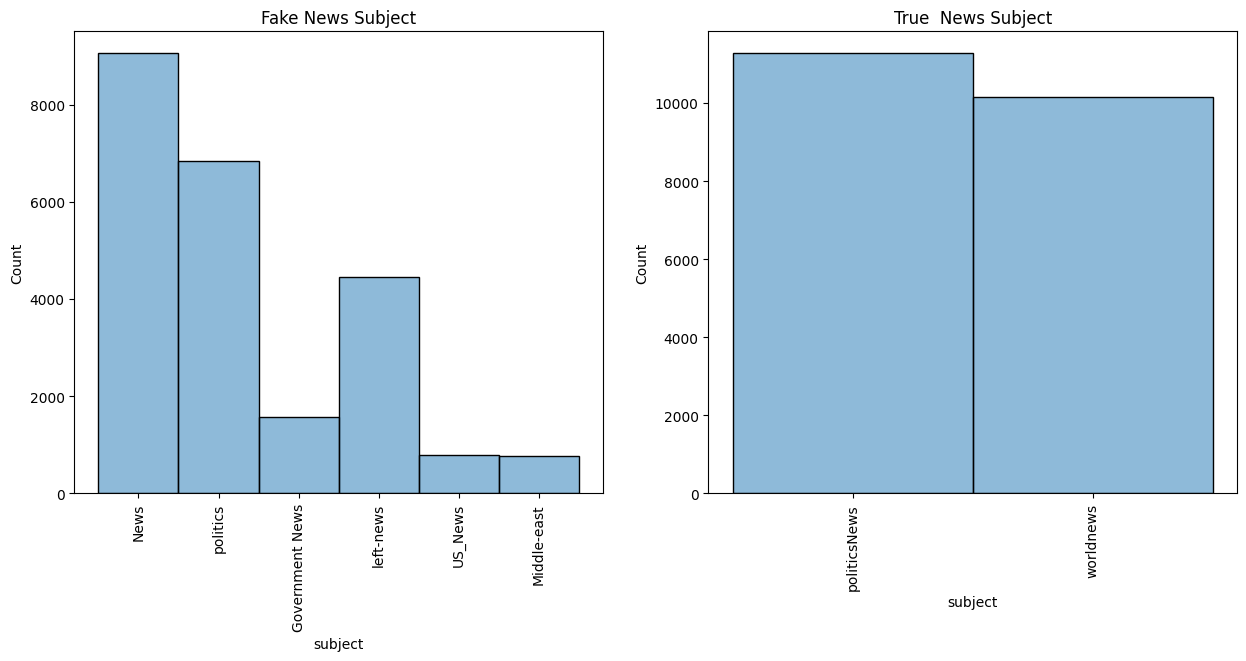

In [ ]:
#Creating Figure
fig, axes = plt.subplots(1,2, figsize = (15,6))
#Adding the histogram1 - Fake News
sns.histplot(df_fake.subject, palette = 'Set1', alpha = 0.5, ax = axes[0])
axes[0].tick_params(axis = 'x', rotation = 90)
axes[0].set_title('Fake News Subject')
#Adding the histogram2 - True News
sns.histplot(df_true.subject, palette = 'Set1', alpha = 0.5, ax = axes[1])
axes[1].tick_params(axis = 'x', rotation = 90)
axes[1].set_title('True  News Subject')

In [ ]:
#Printing the count of Subject
print("Fake News Subject : ",dict(df_fake.subject.value_counts()))
print("True News Subject : ",dict(df_true.subject.value_counts()))

Fake News Subject :  {'News': 9050, 'politics': 6841, 'left-news': 4459, 'Government News': 1570, 'US_News': 783, 'Middle-east': 778}
True News Subject :  {'politicsNews': 11272, 'worldnews': 10145}


In [ ]:
df["text"] = df["title"]+df["text"] #considering text and title as X

**Initializing label values.**

In [ ]:
df['Label'] = df['Label'].map({'True':1, 'Fake':0})


In [ ]:
from sklearn.model_selection import train_test_split
X=df["text"]
y=df["Label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 10)

In [ ]:
from transformers import AutoTokenizer


/home/u194253/Unnati-FakeNews-Detection/fakenews/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def tokenize(X):
  X = tokenizer(text = list(X), add_special_tokens = True, max_length = 100,truncation = True,padding = 'max_length',return_tensors = 'tf',return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
  return X


**Importing pretrained model.**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
X_train_tokens = tokenize(X_train)
X_test_tokens = tokenize(X_test)

2023-06-16 02:31:14.301910: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 02:31:14.344431: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 02:31:14.345657: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 02:31:20.933963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel

In [ ]:
Length = 100


**Network architecture for bert model.**

In [ ]:
def get_model():
  dropout_rate = 0.2
  input_ids = Input(shape = (Length,), dtype = tf.int32, name = 'input_ids')
  input_mask = Input(shape = (Length,), dtype = tf.int32, name = 'input_mask')
  embeddings = bert([input_ids, input_mask])[1] #pooler output
  print(embeddings)
  out = Dropout(0.2)(embeddings)
  out = Dense(20,activation = 'relu')(out)
  out = Dropout(0.2)(out)
  y = Dense(1,activation = 'sigmoid')(out)
  model = Model(inputs=[input_ids, input_mask], outputs=y)
  model.layers[2].trainable = True
  optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, clipnorm=1.0)
  model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')
  return model


In [ ]:
bert = TFBertModel.from_pretrained('bert-base-uncased')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model = get_model()
tf.keras.utils.plot_model(model)

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
from keras.callbacks import EarlyStopping


**Model training was unsuccessfull in Google colab whereas in Intel devcloud it succesfully runs upto 2 epochs with an accuracy of 0.9995 .**

In [ ]:
history = model.fit(x = {'input_ids':X_train_tokens['input_ids'],'input_mask':X_train_tokens['attention_mask']}, y = y_train, epochs=3, validation_split = 0.2, batch_size = 64, callbacks=[EarlyStopping( monitor='val_accuracy' ,mode='max', patience=3,verbose=False,restore_best_weights=True)])

Epoch 1/3
449/449 [==============================] - 3982s 9s/step - loss: 0.0490 - accuracy: 0.9843 - val_loss: 0.0042 - val_accuracy: 0.9994
Epoch 2/3
120/449 [=======>......................] - ETA: 43:04 - loss: 0.0033 - accuracy: 0.9995

In [ ]:
yhat = np.where(model.predict({ 'input_ids' : X_test_seq['input_ids'] , 'input_mask' : X_test_seq['attention_mask']}) >=0.5,1,0)

In [ ]:
print(classification_report(y_test,yhat))
